### 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [2]:
import os
from langgraph.prebuilt import create_react_agent
from langchain.agents import Tool
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, START, END
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 50)
chunks = splitter.split_documents(documents=docs)

embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [4]:
retriever.invoke("What are autonomous agents")

[Document(id='288e749d-202a-4e84-ada7-67552f66857a', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [5]:
def retriever_tool_func(query: str)->str:
    print("Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [6]:
print(retriever_tool_func("What is agents"))

Using RAGRetriever tool
Generative Agents Simulation#
Generative Agents (Park, et al. 2023) is super fun experiment where 25 virtual characters, each controlled by a LLM-powered agent, are living and interacting in a sandbox environment, inspired by The Sims. Generative agents create believable simulacra of human behavior for interactive applications.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:
Boiko et

In [7]:
retriever_tool = Tool(
    name = "RAGRetriever",
    description="Use this to fetch relevant knowlegde base info", 
    func = retriever_tool_func
)
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [8]:
#Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'e:\\workspace\\AI_AGENTS_AND_AGENTIC_AI\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [9]:
from langchain.chat_models import init_chat_model
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = init_chat_model(model = "gpt-4o-mini")

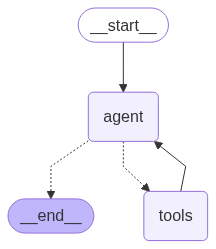

In [10]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------


tools = [retriever_tool, wiki_tool]

# create the native Langgraph react agent
react_node = create_react_agent(llm, tools)
react_node

In [11]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

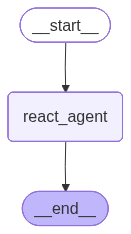

In [12]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------
builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [13]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages":[HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n Final Answer:\n", result["messages"][-1].content)

Using RAGRetriever tool

 Final Answer:
 ### Agent Loop
An agent loop refers to the process in which an agent continually learns and improves its performance over time. This involves feeding the history of its learning experiences back into its model, leading to better predictions and actions in future trials. For example, in the context of large language models (LLMs), such as those used in scientific discovery tasks, the agent can utilize various tools, including internet browsing, documentation reading, code execution, and robotics experimentation APIs. There are several proof-of-concept applications that demonstrate agents powered by LLMs, showcasing their potential as powerful general problem solvers.

### Autonomous Agents
According to Wikipedia, an **autonomous agent** is an artificial intelligence (AI) system that operates independently to perform complex tasks. These agents are a subset of intelligent agents, which perceive their environment and act autonomously to achieve goa

### Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

#### ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [14]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain.agents import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import WikipediaQueryRun
from langchain.utilities import WikipediaAPIWrapper
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_community.document_loaders import TextLoader

In [15]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000021BB8160800>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000021BB8162C00>, root_client=<openai.OpenAI object at 0x0000021BB50B7F50>, root_async_client=<openai.AsyncOpenAI object at 0x0000021BB81607D0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [18]:
### Generic Function to create a retrieval tool 

def make_retriever_tool_from_text(file, name, desc):
    docs = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name, description=desc, func=tool_func)

# Wikipedia Tool
wiki_tool = Tool(
    name="Wikipedia", 
    description="Use this tool to fetch general worl knowledge from Wikipedia.",
    func = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
)


# ArXiv Tool
def arxiv_search(query:str)->str:
    print("Searcing ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool = Tool(
    name = "ArXivSearch",
    description="Use this tool to fetch recent acadamic papers on technical topics.",
    func = arxiv_search
)

In [21]:
internal_tool_1 = make_retriever_tool_from_text(
    "data/internal_docs.txt", 
    "InternaltechDocs", 
    "Search internal tech documents for proprietary architecture and methods."
)
internal_tool_1

Tool(name='InternaltechDocs', description='Search internal tech documents for proprietary architecture and methods.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000021BF16D0D60>)

In [22]:
internal_tool_2 = make_retriever_tool_from_text(
    "data/research_notes.txt", 
    "InternalResearchNotes", 
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x0000021BB823BCE0>)

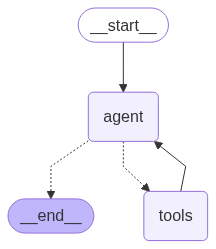

In [24]:
tools = [wiki_tool, arxiv_tool, internal_tool_1, internal_tool_2]

react_node = create_react_agent(llm, tools)
react_node

In [25]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

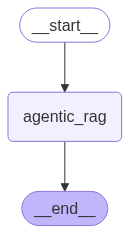

In [26]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph

In [30]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest about transformer variants recently?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

Using tool: InternalResearchNotes
Searcing ArXiv...
Searcing ArXiv...

✅ Final Answer:
 The internal research notes on transformer variants provide several insights:

1. **EfficientFormer**: 
   - Achieved a Top-1 accuracy of 92.4% on TinyImageNet.
   - Peak memory usage is 290MB with a batch size of 16.
   - Successfully deployed on Raspberry Pi 4.
   - Demonstrated effectiveness in quantized int8 mode with no significant accuracy drop.

2. **Longformer**: 
   - Evaluated on customer support logs with a maximum token limit of 8192.
   - Noted a latency of over 1.2 seconds per query in a streaming setting.
   - Observations suggest that chunk-based hybrid attention could help reduce delays.

3. **Reformer**: 
   - Encountered challenges during training, including bucket collisions and inconsistent loss spikes.
   - Sparse gradient updates were observed during LSH attention.
   - Various solutions were attempted, including gradient clipping and the use of memory-efficient attention modu